<a href="https://colab.research.google.com/github/palienko105/Projects/blob/main/MAU_Nday_Retention_PostgreSQL_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Описание БД:
https://docs.google.com/document/d/1qKDKq_d8Mhud5p3mADxWWxlIrPx-EfHzvuE0j02dKtA/edit

#Подключение

In [1]:
!pip install psycopg2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import psycopg2

In [4]:
con = psycopg2.connect(host="89.208.197.76", port = 5432, database="simulative", user="student", password="qweasd963")

In [5]:
cur = con.cursor()

In [6]:
def select (sql):
  return pd.read_sql(sql, con)

In [7]:
sql = '''
select * from information_schema.tables
'''
select (sql)

,table_catalog,table_schema,table_name,table_type,self_referencing_column_name,reference_generation,user_defined_type_catalog,user_defined_type_schema,user_defined_type_name,is_insertable_into,is_typed,commit_action
0,simulative,public,codesubmit,BASE TABLE,None,None,None,None,None,YES,NO,None
1,simulative,public,language,BASE TABLE,None,None,None,None,None,YES,NO,None
2,simulative,public,languagetoproblem,BASE TABLE,None,None,None,None,None,YES,NO,None
3,simulative,public,page,BASE TABLE,None,None,None,None,None,YES,NO,None
4,simulative,public,problem,BASE TABLE,None,None,None,None,None,YES,NO,None
...,...,...,...,...,...,...,...,...,...,...,...,...
188,simulative,information_schema,foreign_data_wrappers,VIEW,None,None,None,None,None,NO,NO,None
189,simulative,information_schema,foreign_server_options,VIEW,None,None,None,None,None,NO,NO,None
190,simulative,information_schema,foreign_servers,VIEW,None,None,None,None,None,NO,NO,None
191,simulative,information_schema,user_mappings,VIEW,None,None,None,None,None,NO,NO,None


# Задача 1

**Расчет MAU.**

Есть набор стандартных метрик, которые нужно знать про свой бизнес вне зависимости от того, какие услуги вы оказываете или какая у вас модель монетизации. К таким метрикам относятся, например, золотая тройка:

* DAU
* WAU
* MAU

Сейчас перед вами стоит задача - написать запрос для расчета MAU на основании заходов пользователей на платформу (UserEntry).

Однако, не забудьте несколько важных моментов:

* В результате вы должны получить лишь 1 число, а не таблицу.
* Если вы будете просто группировать по месяцам, то текущий месяц может испортить статистику, т.к. он неполный (если сегодня не последнее число месяца).
MAU != 4*WAU;      
MAU != 30*DAU      
Поэтому при расчетах давайте руководствоваться следующим соглашением:

Учитываем только месяцы, в которые были заходы на платформу в течение 25 или более дней (не обязательно подряд).

Столбцы в результате:      
В результате нужно вывести один столбец - mau: посчитанная метрика, округленная до целого по правилам математики.

*PostgreSQL:*

In [85]:
sql = '''
with mon_stat as 
(
--Найдем месяцы, в которые были заходы на платформу в течение 25 или более дней (не обязательно подряд).
select to_char(entry_at, 'YYYY-MM') as mm, count(distinct entry_at::date) as cnt_days
from UserEntry
group by to_char(entry_at, 'YYYY-MM')
having count(distinct entry_at::date) >= 25
order by mm
),
mau_table as
(
select to_char(entry_at, 'YYYY-MM') as mm, count(distinct user_id) as MAU
from UserEntry
where to_char(entry_at, 'YYYY-MM') in (select mm from mon_stat)
group by to_char(entry_at, 'YYYY-MM')
)


select round(avg(mau)) as MAU
from mau_table

'''
select (sql)

,mau
0,524.0


*Python:*

In [92]:
sql = '''
select * from UserEntry
'''
df = select(sql)

In [93]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7995 entries, 0 to 7994
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   id        7995 non-null   int64         
 1   entry_at  7995 non-null   datetime64[ns]
 2   page_id   7995 non-null   int64         
 3   user_id   7995 non-null   int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 250.0 KB


In [94]:
df['entry_at_month'] = df['entry_at'].astype('datetime64[M]')

In [95]:
df['entry_at_day'] = df['entry_at'].astype('datetime64[D]')

In [96]:
df

,id,entry_at,page_id,user_id,entry_at_month,entry_at_day
0,1,2021-04-13 08:31:45.000000,4,1,2021-04-01,2021-04-13
1,2,2021-04-11 16:04:20.000000,5,8,2021-04-01,2021-04-11
2,3,2021-04-24 07:29:36.000000,9,4,2021-04-01,2021-04-24
3,4,2021-04-26 20:36:03.000000,2,13,2021-04-01,2021-04-26
4,5,2021-04-27 16:20:12.000000,5,14,2021-04-01,2021-04-27
...,...,...,...,...,...,...
7990,7991,2022-05-24 20:25:00.557579,4,3261,2022-05-01,2022-05-24
7991,7992,2022-05-24 20:22:12.811344,4,3293,2022-05-01,2022-05-24
7992,7993,2022-05-24 20:30:49.899845,4,3294,2022-05-01,2022-05-24
7993,7994,2022-05-24 21:11:10.407605,4,2961,2022-05-01,2022-05-24


Найдем месяцы, в которые были заходы на платформу в течение 25 или более дней (не обязательно подряд).

In [97]:
t = df.groupby('entry_at_month').agg(cnt_users = ('entry_at_day','nunique')).query('cnt_users>=25')

In [98]:
t

,cnt_users
entry_at_month,
2021-11-01,30
2021-12-01,31
2022-01-01,31
2022-02-01,28
2022-03-01,30
2022-04-01,30


Учитываем только месяцы, в которые были заходы на платформу в течение 25 или более дней (не обязательно подряд).

In [99]:
df = df.merge(t, how='left', on='entry_at_month')

In [100]:
df[~df['cnt_users'].isna()].groupby('entry_at_month').agg(MAU=('user_id','nunique')).mean().to_frame()

,0
MAU,524.333333


# Задача 7. Расчет n-day retention.

В рамках исследования с целью смены модели монетизации на платформе IT Resume нам очень интересно посчитать метрику - классический n-day retention. Это поможет нам лучше понять активность пользователей и ответить на многие вопросы. Например:     

Нужно ли вводить бесплатный период или пользователи в целом довольно быстро уходят с платформы?
Какое сейчас значение ретеншен и насколько сильно нам его нужно повышать, чтобы хотя бы несколько месяцев получать деньги за подписку?
На какой день основная масса людей отваливается?

*Нас интересуют конкретные N-дни (по сути, это самые распространенные отсечки времени на практике): 0, 1, 3, 7, 14, 30, 60 и 90 дня. У нас не так много данных, поэтому ограничимся кварталом 😄*

**Важный момент:** Пользователей давайте разобьем по когортам - так намного показательней. В качестве признака когорты будем использовать месяц регистрации пользователя.

**Важный момент:** В ячейках таблицы здесь стоит отношение количества людей, которые пришли в день N и в день 0.

Столбцы в результате
cohort - столбец с когортами (год - месяц)
N (%) - n-day, где N - конкретное число
Значения в таблице округлите до 2 знака после запятой.

Сортировка
Столбцы в результате остортируйте по возрастанию когорт.


* Заходы пользователя на платформу смотрим в таблице UserEntry.
* Когорты при расчете retention формируем по месяцам регистрации пользователей и только начиная с 2022 года.
* При расчетах опирайтесь на реальные дни - 24 часа. Если я зарегистрировался сегодня в 23:59, то не нужно считать, что через 1 минуту уже пошел 1 день. Первый день начнется завтра в 23:59. Это правильней.

*PostgreSQL:*

In [233]:
sql = '''
with svod as 
(
select u.id as user_id, u.date_joined, entry_at, extract(days from entry_at - date_joined) as diff
from users u
left join UserEntry ue
  on u.id = ue.user_id
where u.date_joined >= '2022-01-01'
order by user_id
)

--Считаем n-day retention
select to_char(date_joined, 'YYYY-MM') as cohort,
round(count(distinct case when diff = 0 then user_id end)*100.0/count(distinct case when diff = 0 then user_id end),2) as "0 (%)",
round(count(distinct case when diff = 1 then user_id end) * 100.0/count(distinct case when diff = 0 then user_id end),2) as "1 (%)",
round(count(distinct case when diff = 3 then user_id end) * 100.0/count(distinct case when diff = 0 then user_id end),2) as "3 (%)",
round(count(distinct case when diff = 7 then user_id end) * 100.0/count(distinct case when diff = 0 then user_id end),2) as "7 (%)",
round(count(distinct case when diff = 14 then user_id end) * 100.0/count(distinct case when diff = 0 then user_id end),2) as "14 (%)",
round(count(distinct case when diff = 30 then user_id end) * 100.0/count(distinct case when diff = 0 then user_id end),2) as "30 (%)",
round(count(distinct case when diff = 60 then user_id end) * 100.0/count(distinct case when diff = 0 then user_id end),2) as "60 (%)",
round(count(distinct case when diff = 90 then user_id end) * 100.0/count(distinct case when diff = 0 then user_id end),2) as "90 (%)"

from svod
group by to_char(date_joined, 'YYYY-MM')
'''
t = select (sql)

In [236]:
t

,cohort,0 (%),1 (%),3 (%),7 (%),14 (%),30 (%),60 (%),90 (%)
0,2022-01,100.0,17.46,9.36,5.61,4.99,1.25,0.62,0.42
1,2022-02,100.0,10.65,4.64,2.49,1.36,0.57,0.45,0.34
2,2022-03,100.0,10.71,7.79,2.92,1.70,0.97,0.00,0.00
3,2022-04,100.0,16.26,14.78,7.39,5.91,2.46,0.00,0.00


In [235]:
import seaborn as sns

<AxesSubplot:ylabel='cohort'>

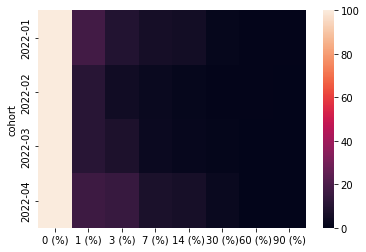

In [238]:
sns.heatmap(t.set_index('cohort'))

*Python:*

Таблица с регистрациями

In [209]:
sql = '''
select * from users
'''
users = select (sql)

Таблица с заходами

In [210]:
sql = '''
select * from UserEntry
'''
UserEntry = select (sql)

In [211]:
users

,id,username,first_name,last_name,is_active,date_joined,email,referal_user,company_id,tier,score
0,198,Pbnnd,None,None,1,2021-11-23 13:58:52.051036,jbsnjbf@gmail.com,NaN,NaN,1,0
1,52,fjbis,Элина,Полякова,1,2021-09-01 12:04:31.148715,fjbis@yandex.ru,NaN,NaN,1,0
2,331,jjxbfox,Эмилия,Афанасьев,1,2021-12-12 07:03:00.583264,jjxbfox@bk.ru,NaN,NaN,1,0
3,416,nsosabisfsobm,None,None,1,2022-01-02 12:22:43.014039,isfsobm.nseo@gmail.com,NaN,1.0,1,0
4,19,Fofbx196,Эмилия,Фролова,1,2021-04-22 15:37:33.000000,koonbnanojj.jofbx@yandex.ru,NaN,NaN,1,0
...,...,...,...,...,...,...,...,...,...,...,...
2769,2161,bbjk,Илья,Иван,1,2022-03-03 19:41:33.865225,bb.jk@bk.ru,NaN,NaN,1,120
2770,2574,odbfonn,Яна,Сухарева,1,2022-04-01 12:31:14.559731,nbjsbjds@mail.ru,NaN,4.0,1,0
2771,2660,cookboo,Артём,Хохлова,1,2022-04-08 21:01:54.011350,cookboo@gmail.com,NaN,NaN,1,25
2772,2816,dbkbxdsaasna,None,None,1,2022-04-21 10:58:08.609494,fdsnbfo@example.org,NaN,4.0,1,0


In [212]:
UserEntry

,id,entry_at,page_id,user_id
0,1,2021-04-13 08:31:45.000000,4,1
1,2,2021-04-11 16:04:20.000000,5,8
2,3,2021-04-24 07:29:36.000000,9,4
3,4,2021-04-26 20:36:03.000000,2,13
4,5,2021-04-27 16:20:12.000000,5,14
...,...,...,...,...
7990,7991,2022-05-24 20:25:00.557579,4,3261
7991,7992,2022-05-24 20:22:12.811344,4,3293
7992,7993,2022-05-24 20:30:49.899845,4,3294
7993,7994,2022-05-24 21:11:10.407605,4,2961


In [213]:
df = users[['id', 'date_joined']].merge(UserEntry[['entry_at', 'user_id']], 
                                        how='left',
                                        left_on='id', right_on='user_id')

In [214]:
df['diff'] = (df['entry_at'] - df['date_joined']).dt.days

In [215]:
df['cohort'] = df['date_joined'].astype('datetime64[M]')

In [216]:
df = df[df['cohort'] >= '2022-01-01']

In [217]:
df

,id,date_joined,entry_at,user_id,diff,cohort
5,416,2022-01-02 12:22:43.014039,2022-01-02 13:11:13.680317,416.0,0.0,2022-01-01
6,416,2022-01-02 12:22:43.014039,2022-01-03 18:14:30.204413,416.0,1.0,2022-01-01
7,416,2022-01-02 12:22:43.014039,2022-01-04 20:15:02.224555,416.0,2.0,2022-01-01
8,416,2022-01-02 12:22:43.014039,2022-01-05 21:29:08.409999,416.0,3.0,2022-01-01
9,416,2022-01-02 12:22:43.014039,2022-01-06 20:41:31.959724,416.0,4.0,2022-01-01
...,...,...,...,...,...,...
7510,2574,2022-04-01 12:31:14.559731,2022-05-08 10:25:35.044838,2574.0,36.0,2022-04-01
7511,2660,2022-04-08 21:01:54.011350,2022-04-08 21:03:45.539891,2660.0,0.0,2022-04-01
7512,2816,2022-04-21 10:58:08.609494,2022-04-21 11:20:12.532798,2816.0,0.0,2022-04-01
7513,2817,2022-04-21 12:20:00.000202,2022-04-21 12:45:39.983869,2817.0,0.0,2022-04-01


Найдем количество уникальных пользователей, которые заходили в n-day

In [220]:
def unique_users(df, df_new):
  for day in [0, 1, 3, 7, 14, 30, 60, 90]:
    df_new[f'r_{day}'] = df[df['diff'] == day].groupby('cohort').agg({'user_id':'nunique'})
  return df_new

In [221]:
svod = pd.DataFrame()

In [222]:
unique_users(df, svod)

,r_0,r_1,r_3,r_7,r_14,r_30,r_60,r_90
cohort,,,,,,,,
2022-01-01,481,84,45,27,24,6,3.0,2.0
2022-02-01,883,94,41,22,12,5,4.0,3.0
2022-03-01,411,44,32,12,7,4,NaN,NaN
2022-04-01,203,33,30,15,12,5,NaN,NaN


Рассчитаем n-day retention

In [223]:
def retention(df, itog):
  for day in [0, 1, 3, 7, 14, 30, 60, 90]:
    itog[f'{day} (%)'] = round(df[f'r_{day}']*100.0 / df['r_0'], 2)
  return itog

In [224]:
retention_table = pd.DataFrame()

In [225]:
retention(svod, retention_table)

,0 (%),1 (%),3 (%),7 (%),14 (%),30 (%),60 (%),90 (%)
cohort,,,,,,,,
2022-01-01,100.0,17.46,9.36,5.61,4.99,1.25,0.62,0.42
2022-02-01,100.0,10.65,4.64,2.49,1.36,0.57,0.45,0.34
2022-03-01,100.0,10.71,7.79,2.92,1.70,0.97,NaN,NaN
2022-04-01,100.0,16.26,14.78,7.39,5.91,2.46,NaN,NaN
